# 灰色预测方法

灰色预测的应用：
+ 时间序列预测：小规模升序时间序列
+ 灾变预测
+ 波形预测
+ 系统预测

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl

mpl.rcParams['font.sans-serif'] = ['FangSong']
mpl.rcParams['axes.unicode_minus'] = False

**例一：灰色预测处理时间序列**

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'])
df.index = df['date']
df = df.drop(['date'], axis=1)
df.head()

,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


In [3]:
class GrayForecast:
    def __init__(self):
        """
        创建序列，整理数据
        """
        pass

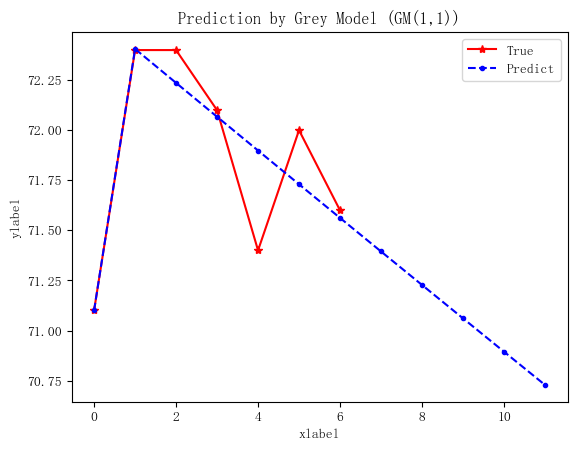

In [13]:
# 线性平移预处理，确保数据级比在可容覆盖范围
def greyModelPreprocess(dataVec):
    "Set linear-bias c for dataVec"
    import numpy as np
    from scipy import io, integrate, linalg, signal
    from scipy.sparse.linalg import eigs
    from scipy.integrate import odeint

    c = 0
    x0 = np.array(dataVec, float)  # 将原来的数据转换为float类型并作为
    n = x0.shape[0]
    L = np.exp(-2 / (n + 1))
    R = np.exp(2 / (n + 2))
    xmax = x0.max()
    xmin = x0.min()
    if (xmin < 1):
        x0 += (1 - xmin)
        c += (1 - xmin)
    xmax = x0.max()
    xmin = x0.min()
    lambda_ = x0[0:-1] / x0[1:]  # 计算级比
    lambda_max = lambda_.max()
    lambda_min = lambda_.min()
    while (lambda_max > R or lambda_min < L):
        x0 += xmin
        c += xmin
        xmax = x0.max()
        xmin = x0.min()
        lambda_ = x0[0:-1] / x0[1:]
        lambda_max = lambda_.max()
        lambda_min = lambda_.min()
    return c


# 灰色预测模型
def greyModel(dataVec, predictLen):
    "Grey Model for exponential prediction"
    # dataVec = [1, 2, 3, 4, 5, 6]
    # predictLen = 5
    import numpy as np
    from scipy import io, integrate, linalg, signal
    from scipy.sparse.linalg import eigs
    from scipy.integrate import odeint

    x0 = np.array(dataVec, float)
    n = x0.shape[0]
    x1 = np.cumsum(x0)
    B = np.array([-0.5 * (x1[0:-1] + x1[1:]), np.ones(n - 1)]).T
    Y = x0[1:]
    u = linalg.lstsq(B, Y)[0]

    def diffEqu(y, t, a, b):
        return np.array(-a * y + b)

    t = np.arange(n + predictLen)
    sol = odeint(diffEqu, x0[0], t, args=(u[0], u[1]))
    sol = sol.squeeze()
    res = np.hstack((x0[0], np.diff(sol)))
    return res


# 输入数据
dB = [71.1, 72.4, 72.4, 72.1, 71.4, 72.0, 71.6]

# x = np.array([-18, 0.34, 4.68, 8.49, 29.84, 50.21, 77.65, 109.36])
x = np.array(dB)
# x = value
c = greyModelPreprocess(x)
x_hat = greyModel(x + c, 5) - c

# 画图
t1 = range(x.size)
t2 = range(x_hat.size)
plt.plot(t1, x, color='r', linestyle="-", marker='*', label='True')
plt.plot(t2, x_hat, color='b', linestyle="--", marker='.', label="Predict")
plt.legend(loc='upper right')
plt.xlabel('xlabel')
plt.ylabel('ylabel')
plt.title('Prediction by Grey Model (GM(1,1))')
plt.show()

In [18]:
x_ = x_hat[:7]
np.sqrt((x - x_) ** 2)

array([0.        , 0.00574242, 0.16376344, 0.0328715 , 0.49841633,
       0.26990088, 0.03782405])

In [19]:
def calc_squred_diff(list1, list2):
    """
    计算预测数值与原始数值的误差函数
    :param list1: 原始时间序列
    :param list2: 预测时间序列
    :return: 两个序列之间的标准差 // 原始序列数值
    """
    len = min(list1.shape[-1], list2.shape[-1])
    li1, li2 = list1[0:len], list2[0:len]
    std_err = np.sqrt((li1 - li2) ** 2)
    return std_err / list1

<BarContainer object of 7 artists>

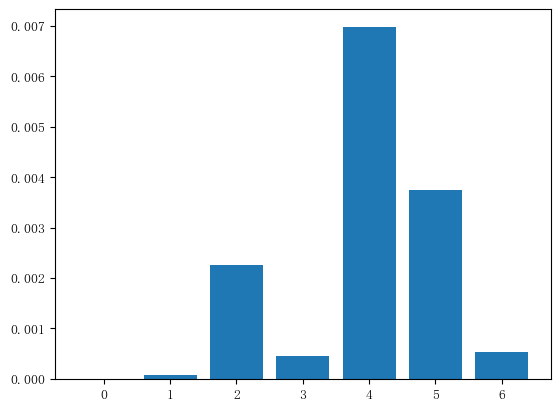

In [23]:
calc_squred_diff(x, x_hat)
plt.bar(np.arange(7), calc_squred_diff(x, x_hat))

In [21]:
np.arange(7)

array([0, 1, 2, 3, 4, 5, 6])

In [5]:
value = df['value'].tolist()

In [7]:
value = np.array(value)

In [27]:
# 灰色预测模型GM(2,1)
def greyModel2(dataVec, predictLen):
    "Grey Model for exponential prediction"
    # dataVec = [1, 2, 3, 4, 5, 6]
    # predictLen = 5
    import numpy as np
    import sympy as sy
    from scipy import io, integrate, linalg, signal

    x0 = np.array(dataVec, float)
    n = x0.shape[0]
    a_x0 = np.diff(x0)  # 1次差分序列
    x1 = np.cumsum(x0)  # 1次累加序列
    z = 0.5 * (x1[0:-1] + x1[1:])  # 均值生成序列
    B = np.array([-x0[1:], -z, np.ones(n - 1)]).T
    u = linalg.lstsq(B, a_x0)[0]

    def diffEqu(x, f, a1, a2, b):
        return sy.diff(f(x), x, 2) + a1 * sy.diff(f(x), x) + a2 * f(x) - b  # f''(x)+a1*f'(x)+a2*f(x)=b 二阶常系数齐次微分方程

    t = np.arange(n + predictLen)
    x = sy.symbols('x')  # 约定变量
    f = sy.Function('f')  # 约定函数
    eq = sy.dsolve(diffEqu(x, f, u[0], u[1], u[2]), f(x), ics={f(t[0]): x1[0], f(t[n - 1]): x1[-1]})
    f = sy.lambdify(x, eq.args[1], 'numpy')
    sol = f(t)
    res = np.hstack((x0[0], np.diff(sol)))
    return res


In [28]:
# 司守奎P403 GM(2,1)模型
seq = np.array([41, 49, 61, 78, 96, 104])
greyModel2(seq, 3)

array([ 41.        ,  51.01481441,  63.14123779,  77.21114017,
        92.15478971, 104.47801792, 104.68156355,  68.68742438,
       -62.62027918])

In [31]:
calc_squred_diff(seq, greyModel2(seq, 3))

array([0.        , 0.04111866, 0.03510226, 0.01011359, 0.04005427,
       0.00459633])

array([0.        , 0.04111866, 0.03510226, 0.01011359, 0.04005427,
       0.00459633])

<BarContainer object of 6 artists>

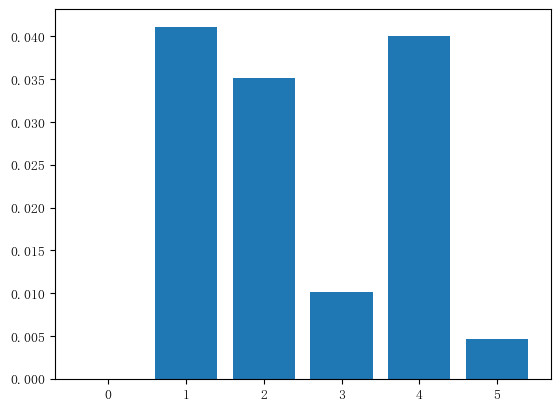

In [32]:
plt.bar(np.arange(6), calc_squred_diff(seq, greyModel2(seq, 3)))

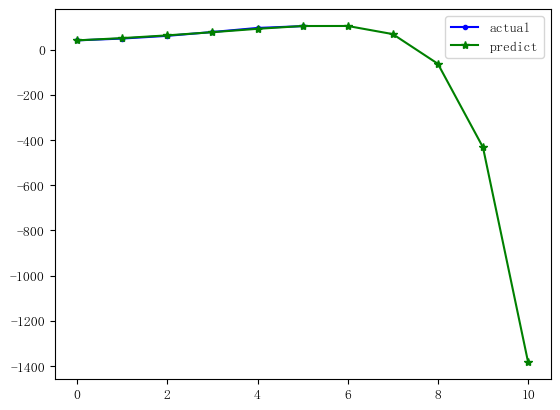

In [38]:
plt.plot(np.arange(6), seq, 'b-', marker='.', label='actual')
plt.plot(np.arange(greyModel2(seq, 5).shape[-1]), greyModel2(seq, 5), 'g-', marker='*', label='predict')
plt.legend()
plt.show()

In [40]:
# 首先引入包
import matplotlib.pyplot
import numpy as np
import matplotlib.pyplot as plt
import math as mt

# 原始序列
X0 = [89677, 99215, 109655, 120333, 135823, 159878, 182321, 209407, 246619, 300670]

# 计算轴向元素累加和
X1 = [89677]
add = X0[0] + X0[1]
X1.append(add)
i = 2
while i < len(X0):
    add = add + X0[i]
    X1.append(add)
    i += 1
print("X1", X1)
M = []
j = 1
while j < len(X1):
    num = (X1[j] + X1[j - 1]) / 2
    M.append(num)
    j = j + 1
print("M", M)

# 最小二乘法
Y = []
x_i = 0
while x_i < len(X0) - 1:
    x_i += 1
    Y.append(X0[x_i])
Y = np.mat(Y).T
Y.reshape(-1, 1)
print("Y", Y)
B = []
b = 0
while b < len(M):
    B.append(-M[b])
    b += 1
print("B:", B)
B = np.mat(B)
B.reshape(-1, 1)
B = B.T
c = np.ones((len(B), 1))
B = np.hstack((B, c))
print("c", c)
print("b", B)

# 设置参数
beta = np.linalg.inv(B.T.dot(B)).dot(B.T).dot(Y)
a = beta[0]
b = beta[1]
const = b / a
print(beta)
print(type(beta))

# 预测模型
F = [X0[0]]
k = 1
while k < len(X0) + 10:
    F.append((X0[0] - const) * mt.exp(-a * k) + const)
    k += 1
print("F", F)

# 得到预测序列
x_hat = [X0[0]]
g = 1
while g < len(X0) + 10:
    print(g)
    x_hat.append(F[g] - F[g - 1])
    g += 1
X0 = np.array(X0)
x_hat = np.array(x_hat)
print(x_hat)

# 设置时间序列
t1 = range(1999, 2009)
t2 = range(1999, 2019)

# 结果可视化
plt.plot(t1, X0, color='r', linestyle="--", label='true')
plt.plot(t2, x_hat, color='b', linestyle="--", label="predict")
plt.legend(loc='upper right')
plt.xlabel('year')
plt.ylabel('Profit')
plt.title('Profit prediction for company by Grey model')
plt.show()

X1 [89677, 188892, 298547, 418880, 554703, 714581, 896902, 1106309, 1352928, 1653598]
M [139284.5, 243719.5, 358713.5, 486791.5, 634642.0, 805741.5, 1001605.5, 1229618.5, 1503263.0]
Y [[ 99215]
 [109655]
 [120333]
 [135823]
 [159878]
 [182321]
 [209407]
 [246619]
 [300670]]
B: [-139284.5, -243719.5, -358713.5, -486791.5, -634642.0, -805741.5, -1001605.5, -1229618.5, -1503263.0]
c [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
b [[-1.3928450e+05  1.0000000e+00]
 [-2.4371950e+05  1.0000000e+00]
 [-3.5871350e+05  1.0000000e+00]
 [-4.8679150e+05  1.0000000e+00]
 [-6.3464200e+05  1.0000000e+00]
 [-8.0574150e+05  1.0000000e+00]
 [-1.0016055e+06  1.0000000e+00]
 [-1.2296185e+06  1.0000000e+00]
 [-1.5032630e+06  1.0000000e+00]]
[[-1.46001334e-01]
 [ 6.98910055e+04]]
<class 'numpy.matrix'>
F [89677, matrix([[179024.75488171]]), matrix([[282417.77419757]]), matrix([[402063.94166313]]), matrix([[540518.21530675]]), matrix([[700737.18676441]]), matrix([[886142.21717195]]), matrix([[1100692

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (20,) + inhomogeneous part.

In [ ]:
def isInRange(seq):
    len = seq.shape[-1]
    _lambda = []
    for i in range(len):
        _lambda.append(seq[i] / seq[i + 1])
    max_lambda = np.max(_lambda)
    min_lambda = np.min(_lambda)
    Theta = (np.exp(-(2 / len + 1)), np.exp(2 / len + 1))
    if min_lambda >= Theta[0] and max_lambda <= Theta[-1]:
        return True
    return False

def GM11Model(seq):
    if isInRange(seq):
        
    else:
        Shift(seq)


def Shift(seq):
    """
    如果时间序列不满足GM（1，1）模型的要求，那么进行平移处理，知道满足要求
    :param seq:
    :return:
    """
    pass

In [41]:
li = [12, 34, 12, 453, 121, 4312.542]
np.max(li)

4312.542